Question:
How does increased medical capabilities impact population growth, specifically around age demographics?

In order to answer this question, we used life expectancy as a proxy for increased medical capabilities.

In [113]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [114]:
#read csv file that contains our data for world population, life expectancy, and fertility rate
from pandas import read_csv
filename = 'project1data.csv'
tables = read_csv(filename, header=0, index_col=0, decimal='M');

In [125]:
def plot_results(un, ts_young, ts_middle, ts_old, timeseries, title):
    """Plot the estimates and the model.
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(un, '--', label='UN DESA')
    plot(ts_young, color='blue', label='ages 0-14')
    plot(ts_middle, color='black', label='ages 15-44')
    plot(ts_old, color='green', label='ages 45+')
    plot(timeseries, color='gray', label='total')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Our notebook was confused by decimals so within our data set we 
multiplied our numbers by 1000 in order to get rid of the decimals, 
so we then had to divide by 1000

In [126]:
life_expectancy = tables._expectancyx1000/1000
birth_rate = tables.birthrate10000/10000
fer_rate = tables.fer_ratex1000/1000
un = tables.UN / 1e9; #In billions

In order to divide the population into young middle and old, 
we found the global age demographics in 1965: 37.8% under 15, 
42.2% between 15 and 44, and 20% 45 and older.

In [127]:
young = get_first_value(un) * 0.378
old= get_first_value(un) * 0.2
middle = get_first_value(un)*0.422
init = State(young=young, middle=middle, old=old);

We said that 1 divided by the age range of elderly people would be the death rate, assuming that every person dies at their life expectancy. 

Similarily, we took data for fertility rates and divided it by the age range of the middle group, specifically for women, because this is the time when they could be having kids.

In [ ]:
death_rate = 1/((life_expectancy)-44)
birth_rate = fer_rate/(31*2);
#children per woman in her fer age per year

To determine how many people mature from kids to adults, we took one divided by the youngest age range, and people go from the middle to oldest group at a rate of one divided by the middle age group.

In [128]:
system = System(mature_rate = 1/14,
                elder_rate = 1/31,
                t_0 = 1965,
                t_end = 2016,
                init=init);

In our update function, we used the middle population, the ones who are giving birth, to determine the numbers of births, and add the newborn to the young pop. Deaths are determined by the old age group and are subtracted from that group. It also determines, using the mature and elder rates, what percent of each group moves from young to middle and middle to old.

In [129]:
def update_func1(state, t, system):
    birth_rate2 = birth_rate[t] #calls on birth rate defined earlier based on fertility rates over time
    births = birth_rate2*state.middle #determines how many people are born based on the birth rate times the middle age group
    maturings = system.mature_rate * state.young #determines how many people mature from the young pop to middle pop
    agings = system.elder_rate * state.middle #determines how many people age from middle to old pop
    death_rate2 = death_rate[t] #calls on death rate defined earlier based on life expectancy data over time
    deaths = death_rate2 * state.old  #determines how many people die based on the death rate times the old age group
    young = state.young + births - maturings #the updated young population adds the newborns and subtracts those who matured
    middle = state.middle + maturings - agings #the updated middle population adds the matured and subtracts those who grew old
    old = state.old + agings - deaths #the updated old population adds those who grew old and subtracts those who died
    
    return State(young=young, middle=middle, old=old)
    

In [130]:
state = update_func1(init, system.t_0, system)

,values
young,1.282386
middle,1.449457
old,0.639248


In [131]:
state = update_func1(state, system.t_0, system);

In [132]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    init: initial State object
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results_young = TimeSeries()
    results_middle = TimeSeries()
    results_old = TimeSeries()
    
    state = system.init
    results[system.t_0] = state.young + state.middle + state.old
    
    for t in linrange(system.t_0, system.t_end):
        state = update_func(state, t, system)
        results[t+1] = state.young + state.middle + state.old
        results_young[t+1] = state.young
        results_middle[t+1] =state.middle
        results_old[t+1] =state.old
        
    return results, results_young, results_middle, results_old

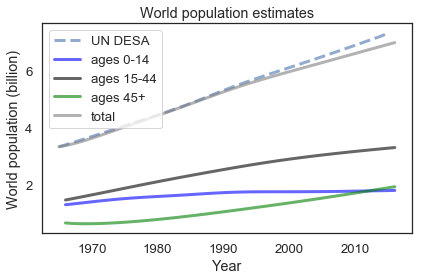

In [133]:
results = run_simulation(system, update_func1)[0];
results_young = run_simulation(system, update_func1)[1];
results_middle = run_simulation(system, update_func1)[2];
results_old = run_simulation(system, update_func1)[3];
plot_results(un, results_young, results_middle, results_old, results, 'World population estimates')

Results:
As the life expectancy gets bigger, the youngest age group levels off as the other groups get more population. The elder group population grows fastest. The curves of young and aged population are even going to intersect.

Interpretation:

As the life expectancy gets longer, the old age group constantly grows bigger and the young population (or the birth rate) is actually decreasing.

The model (added up 3 age groups) fits well with actual population, especially until around 1990, and the trends of age demographics shows that with the increased medical level, people have fewer children and can live longer.

To make this model fit better after 1990, we would need to alter the ages in each age group, because as medical levels improve, older people can have kids and people die older, so the middle group should be larger and the older group should start older.